# Coding Task Data Generation

## Table of Contents
- Data Generation
- Simulating Treatment Effects
- Post-Simulation Analysis

## Data Generation
### Importing Needed libraries
This notebook assumes that the working directory is the root of the project folder. Otherwise, change the directory using `os.chdir()`.

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')
import seaborn as sns

# Importing Custom Scripts For This Project
from scripts.network_generation import diffusion_network
from scripts.data_generation import generate_weights,generate_demographics,generate_attitudes
from scripts.treatment_simulation import apply_treatment, assign_block_treatment

# Set random seed for reproducibility
np.random.seed(111)

### Generating Demographic Information

In [2]:
demographics_df = generate_demographics(n=5000)
demographics_df.head(1)

,demographic_age,demographic_income,demographic_education,demographic_unobs_grp
0,53,137.883039,6,A


### Generating Attitudes Towards Vaccination

In [3]:
attitudes_df = generate_attitudes(demographics_df,
                                  demographic_cont_vars=['demographic_age','demographic_income','demographic_education'],
                                  demographic_cat_vars='demographic_unobs_grp')
print(demographics_df.shape)
attitudes_df.head(1)

(5000, 4)


,att_covid,att_vaccine,att_safety,att_unobserved
0,2,5,3,5


### Generating Network Structure

 Network Generation Successful
 Network Fully Connected: True
 Number of Nodes: 5000
 Number of Edges: 14400
 Average Clustering: 0.19223701147097985
 Modularity: 0.9027644410686728


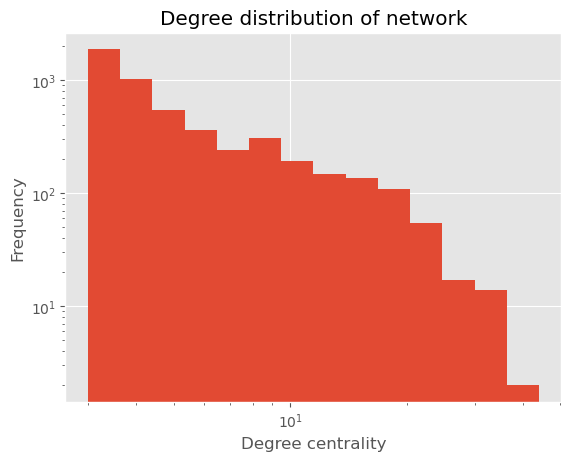

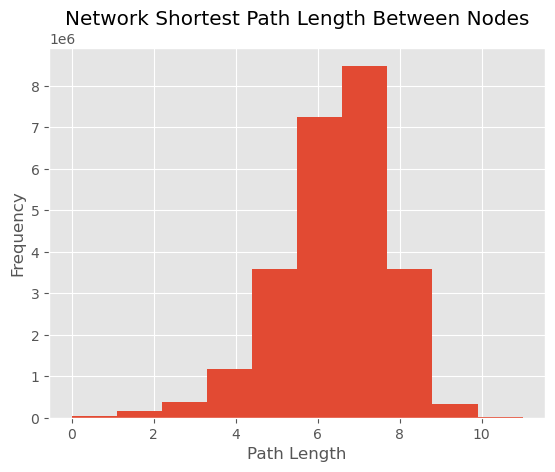

In [4]:
this_network = diffusion_network(attitudes_df)

Simulate the diffusion of initial attitudes

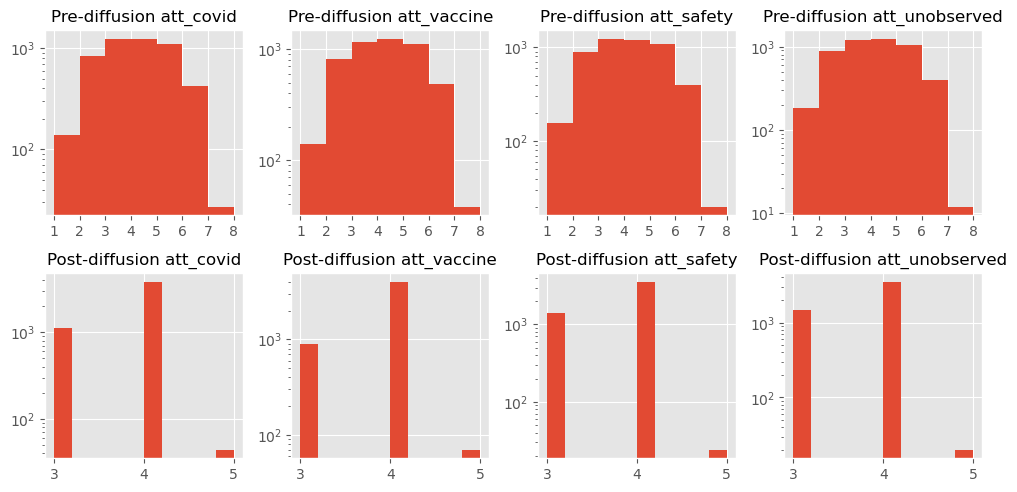

In [5]:
fig, ax = plt.subplots(nrows=2,ncols=4,squeeze=False,figsize=(10,5))
for i, attitude in enumerate(attitudes_df.columns):

    # Plot distribution of pre diffusion values
    ax[0,i].hist(attitudes_df[attitude],bins = range(1,9))
    ax[0,i].set_title('Pre-diffusion ' + str(attitude),fontsize=12)
    ax[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0,i].set_yscale('log')

    # Plot distribution of post diffusion values
    attitudes_df[attitude] = this_network.fj_diffusion(attitudes_df[attitude])
    ax[1,i].hist(attitudes_df[attitude])
    ax[1,i].set_title('Post-diffusion ' + str(attitude),fontsize=12)
    ax[1,i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1,i].set_yscale('log')

fig.tight_layout(pad=1.0)
plt.savefig('figures/pre_treatment_diffusion.png')
plt.show()

### Saving Data

Export edgelist and nodelist to csv for Gephi visualizations

In [6]:
# Export community list for Gephi visualization
this_network.node_community.to_csv('figures/gephi/community.csv')

# Export edgelist for Gephi visualization
this_network.export_edgelist(filename='figures/gephi/edgelist.csv') # export to gephi folder

# Export nodelist for Gephi
nodelist = attitudes_df['att_safety']
nodelist.index.name = 'id'
nodelist.to_csv('figures/gephi/nodelist.csv')

Export pre-treatment survey to csv

In [7]:
pre_treatment_df = pd.merge(attitudes_df,demographics_df,how='inner',left_index=True,right_index=True)
pre_treatment_df = pre_treatment_df.drop(columns=['att_unobserved','demographic_unobs_grp']) # Drop unobserved colummns
pre_treatment_df.head(1)

,att_covid,att_vaccine,att_safety,demographic_age,demographic_income,demographic_education
id,,,,,,
0,3.0,4.0,4.0,53,137.883039,6


In [8]:
# Save to file
pre_treatment_df.to_csv('data/pre_treatment.csv')

## Simulating Treatment Effects

In [9]:
treatment_assignment_df = assign_block_treatment(this_network)
treatment_assignment_df.to_csv('data/treatment_assignment.csv') # Save to file
treatment_assignment_df.head(1)

,community,treatment_emotion,treatment_reason
id,,,
0,93,False,False


Model effects of treatment on attitudes

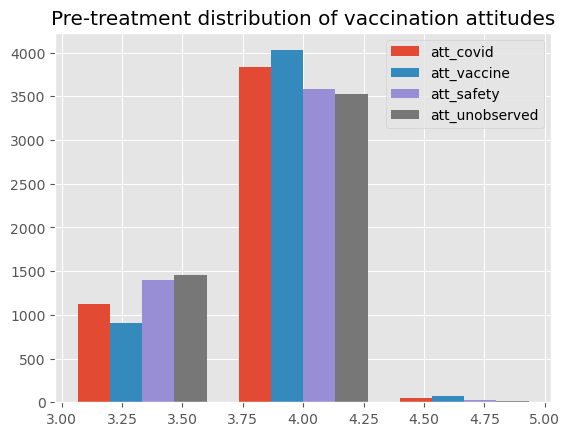

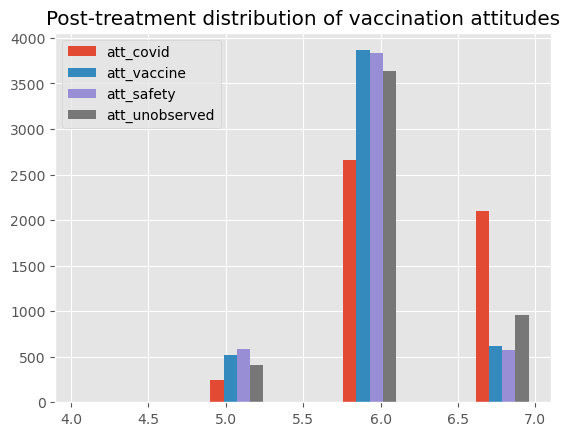

In [10]:
attitudes_df = apply_treatment(attitudes_df,treatment_assignment_df,this_network)

### Model propensity to vaccinate

In [11]:
# Probability of vaccinating
weights = generate_weights(4)
vaccine_prob = np.zeros_like(attitudes_df.iloc[:,1])
for i,attitude in enumerate(attitudes_df.columns): # Weighted mean of each attitude
    vaccine_prob += attitudes_df[attitude] * weights[i]
vaccine_prob = vaccine_prob/10 # Normalize 10-point attitude scale into probability 
vaccine_prob = vaccine_prob + np.random.normal(0,0.1) # Add random error

# Convert vaccine probability into vaccination outcome
post_survey = attitudes_df.copy(deep=True)
post_survey['vaccine'] = (vaccine_prob > np.random.uniform(0,1,5000))
post_survey.head(1)

,att_covid,att_vaccine,att_safety,att_unobserved,vaccine
id,,,,,
0,6,6,6,6,True


### Save post-treatment survey

Drop random rows to simulate 500 entries with attrition

In [12]:
# Mask 500 random entries
rows_to_drop = np.random.choice(range(0,5000),500,replace=False)
post_survey = post_survey.astype('int').astype('float')
post_survey.loc[rows_to_drop,:] = np.nan

# Drop unobserved variable
post_survey = post_survey.drop(columns=['att_unobserved'])

post_survey.head(1)

,att_covid,att_vaccine,att_safety,vaccine
id,,,,
0,6.0,6.0,6.0,1.0


In [13]:
post_survey.to_csv('data/post_treatment.csv')

## Post-Simulation Analysis 

Clear data cache and re-import packages

In [ ]:
% reset -f

# Re-import packages
import pandas as pd
import numpy as np
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns

Combining the dataframes

In [15]:
pre_treatment_df = pd.read_csv('data/pre_treatment.csv',index_col='id')
random_assignment_df = pd.read_csv('data/treatment_assignment.csv',index_col='id')
post_treatment_df = pd.read_csv('data/post_treatment.csv',index_col='id')

# Rename variables to indicate if they're from pre or post_treatment
pre_treatment_df.columns = ['pre_' + x for x in pre_treatment_df.columns]
post_treatment_df.columns = ['post_' + x for x in post_treatment_df.columns]

# Merge all dataframes together
merged_df = pre_treatment_df.merge(random_assignment_df,left_index=True,right_index=True,how='inner',validate='1:1')
merged_df = merged_df.merge(post_treatment_df,how='inner',left_index=True,right_index=True,validate='1:1')
merged_df.head(50)

# Drop attritioned entries
merged_df = merged_df.dropna()

merged_df.head(1)

,pre_att_covid,pre_att_vaccine,pre_att_safety,pre_demographic_age,pre_demographic_income,pre_demographic_education,community,treatment_emotion,treatment_reason,post_att_covid,post_att_vaccine,post_att_safety,post_vaccine
id,,,,,,,,,,,,,
0,3.0,4.0,4.0,53,137.883039,6,93,False,False,6.0,6.0,6.0,1.0


In [16]:
# Defining a few sets of variables
base_att = ['att_covid','att_safety','att_vaccine']
pre_att = ['pre_att_covid','pre_att_safety','pre_att_vaccine']
post_att = ['post_att_covid','post_att_safety','post_att_vaccine']
demographics = ['pre_demographic_age', 'pre_demographic_income', 'pre_demographic_education']
treatments = ['treatment_emotion','treatment_reason']
outcome = 'post_vaccine'

### Basic regression table:
Analyzing the experiment's treatment effects on an individual-level suggests that the treatments **do** have a statistically significant effect on increasing vaccine uptake.
- The table below suggests that the emotion-based ads increased one's tendency to vaccinate by **7.4%**
- The table below suggests that the reason-based ads increased one's tendency to vaccinate by **4.0%**
- However, few covariances do a good job of predicting vaccination outcome, suggesting that treatment

In [17]:
regressions = [treatments,demographics + treatments,pre_att + demographics + treatments]
reg_outcomes = []

for regression in regressions:
    X = sm.add_constant(merged_df[regression]).astype('float')
    Y = merged_df[outcome].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table

### Attitudes as mechanism
As the Directed Acyclic Graph (DAG) below shows, we generate the data in a way that treatment affects vaccination propensity indirectly through component attitudes.

![DAG](figures/dags/treatment_DAG.drawio.png)

The below analysis firstly confirms a correlation between vaccinate attitudes, treatment, and vaccination propensity.
- The regression below suggests that the treatment did significantly push individual attitudes towards pro-vaccination by around **1 point** on the likert scale.
- The regression table shows that **individuals who already have a high opinion of vaccination were less affected by the treatment**. This phenomenon is likely because the diffusion of opinions throughout the network homogenized in-group opinions, thus reducing extremely high opinions. The network structure is likely responsible for this phenomenon because this feature was not part of the treatment effect generation process.

In [18]:
# Initialize heterogenous treatment effect's interactive variables
regressions = []
for att in pre_att:
    merged_df[att +' * treatment_emotion'] = merged_df[att] * merged_df['treatment_emotion']
    merged_df[att + ' * treatment_reason'] = merged_df[att] * merged_df['treatment_reason']
    regressions.append(treatments + [att,att +' * treatment_emotion',att + ' * treatment_reason'])

outcome_vars = post_att
reg_outcomes = []

for i in range(0,len(outcome_vars)):
    X = sm.add_constant(merged_df[regressions[i]]).astype('float')
    Y = merged_df[outcome_vars[i]].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table.custom_columns(outcome_vars)
reg_table

In [19]:
"""
for att in base_att:

    # Merge all needed plots into one big dataframe
    plot_df = pd.merge(merged_df['pre_'+att].rename('Pre-Treatment'),
                       merged_df[~(merged_df['treatment_reason'].astype('bool') | merged_df['treatment_emotion'].astype('bool'))]['post_'+att].rename('Control Group'),
                       how='outer',left_index=True,right_index=True)
    plot_df = pd.merge(plot_df,merged_df[merged_df['treatment_emotion'].astype('bool')]['post_'+att].rename('Treatment Emotion'),
                       how='outer',left_index=True,right_index=True)
    plot_df = pd.merge(plot_df,merged_df[merged_df['treatment_reason'].astype('bool')]['post_'+att].rename('Treatment Reason'),
                       how='outer',left_index=True,right_index=True)
    

    # Execute the Plot
    plt.hist(plot_df)
    plt.xlabel('Average opinion')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+att)
    plt.legend(plot_df.columns)
    plt.show()
"""

"\nfor att in base_att:\n\n    # Merge all needed plots into one big dataframe\n    plot_df = pd.merge(merged_df['pre_'+att].rename('Pre-Treatment'),\n                       merged_df[~(merged_df['treatment_reason'].astype('bool') | merged_df['treatment_emotion'].astype('bool'))]['post_'+att].rename('Control Group'),\n                       how='outer',left_index=True,right_index=True)\n    plot_df = pd.merge(plot_df,merged_df[merged_df['treatment_emotion'].astype('bool')]['post_'+att].rename('Treatment Emotion'),\n                       how='outer',left_index=True,right_index=True)\n    plot_df = pd.merge(plot_df,merged_df[merged_df['treatment_reason'].astype('bool')]['post_'+att].rename('Treatment Reason'),\n                       how='outer',left_index=True,right_index=True)\n    \n\n    # Execute the Plot\n    plt.hist(plot_df)\n    plt.xlabel('Average opinion')\n    plt.ylabel('Frequency')\n    plt.title('Distribution of '+att)\n    plt.legend(plot_df.columns)\n    plt.show()\n"

### Block-Level Treatment Effect

Observing the underlying network structure, one would realize that vaccination-rate is highly correlated with the community that the individual is part of. This suggests that block-level treatment has been effective because one primarily sees between-group differences, rather than in-group differences in vaccine propensity.

The following code allows us to shade a node based on its predicted propensity towards vaccination (PPV), rather than actual observed outcome. Visualizing the PPV on a network using Gephi, one can observe that vaccination propensity is highly homogenous within each community, supporting the hypothesis that the treatment primarily worked by converting the opinion of entire 'blocks'.

In [20]:
# Create a predicted probability of vaccination based on post-attitudes. Train model:
Y = merged_df['post_vaccine']
X = merged_df[post_att]
reg = LogisticRegression().fit(X, Y)

# Predict probability of vaccination
merged_df['post_vaccine_proba'] = reg.predict_proba(X)[:,1]

# Rank transform the probabilities to highlight contrast
merged_df['post_vaccine_proba'] = merged_df['post_vaccine_proba'].rank()

In [21]:
# Export vaccination information to Gephi for visualization
vaccine_nodelist = merged_df['post_vaccine_proba'].to_csv('figures/gephi/vaccine_nodelist.csv')

Gephi visualization: (black nodes represents nodes with missing data)

![Gephi graph legend](figures/gephi/vaccine_propensity_legend.png)
![Gephi graph showing within-community heterogeneity](figures/gephi/vaccine_propensity.png)

Running the same regression table on a block level also confirms the earlier hypothesis, showing a significant block-level treatment effect. The magnitudes of the treatment effect between block and individual-level analysis are also highly similar, which increases one's confidence in the analysis.
- The table below suggests that the emotion-based ads increased one's tendency to vaccinate by **7.4%**
- The table below suggests that the reason-based ads increased one's tendency to vaccinate by **4.2%**

In [22]:
merged_df=merged_df.groupby('community',observed=False).mean()
print(merged_df.shape)
merged_df.head(1)

(100, 19)


,pre_att_covid,pre_att_vaccine,pre_att_safety,pre_demographic_age,pre_demographic_income,pre_demographic_education,treatment_emotion,treatment_reason,post_att_covid,post_att_vaccine,post_att_safety,post_vaccine,pre_att_covid * treatment_emotion,pre_att_covid * treatment_reason,pre_att_safety * treatment_emotion,pre_att_safety * treatment_reason,pre_att_vaccine * treatment_emotion,pre_att_vaccine * treatment_reason,post_vaccine_proba
community,,,,,,,,,,,,,,,,,,,
0,3.915254,4.0,4.016949,50.508475,139.410132,3.559322,1.0,0.0,6.745763,6.220339,6.220339,0.627119,3.915254,0.0,4.016949,0.0,4.0,0.0,3129.974576


In [23]:
reg_outcomes = []
outcome_vars = post_att + ['post_vaccine',]
for att in outcome_vars:
    X = sm.add_constant(merged_df[treatments + pre_att]).astype('float')
    Y = merged_df[att].astype('float')
    reg_outcomes.append(sm.OLS(Y,X).fit())

reg_table = Stargazer(reg_outcomes)
reg_table.custom_columns(outcome_vars)
reg_table

### Network Interference
This section shows that due to the effects of interference, the treatment also had an effect on the control group. 
- The graphs below shows that compared to pre-treatment levels, the treatment increased the control group's propensity to vaccinate by **about 20%**, while treatments increased the treated groups' propensity to vaccinate by **about 25%**.
- This means that network interference caused the previous analysis comparing control and treated groups to return a highly conservative estimate of the treatment effect, causing the project to underestimate the treatment effect by **about 20%.**
- It would be difficult to measure the true magnitude of underestimation due to network interference in a real-life situation because one cannot know/assume that no other factors (besides the treatment) intervened to cause this difference between pre-treatment and post-treatment.

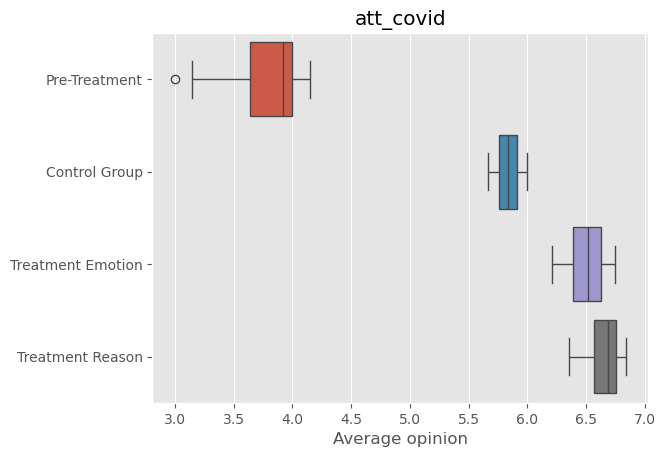

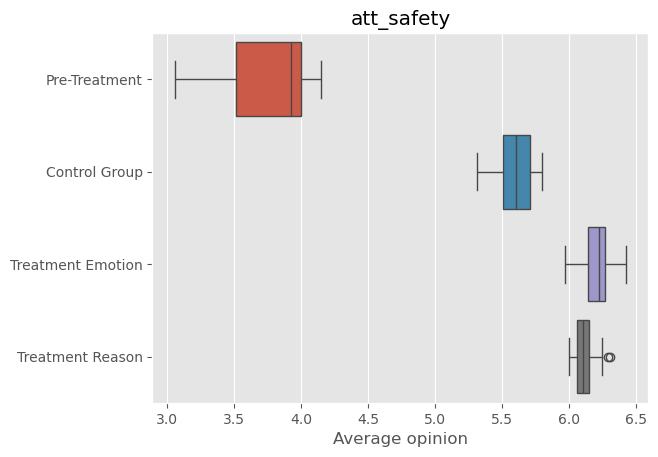

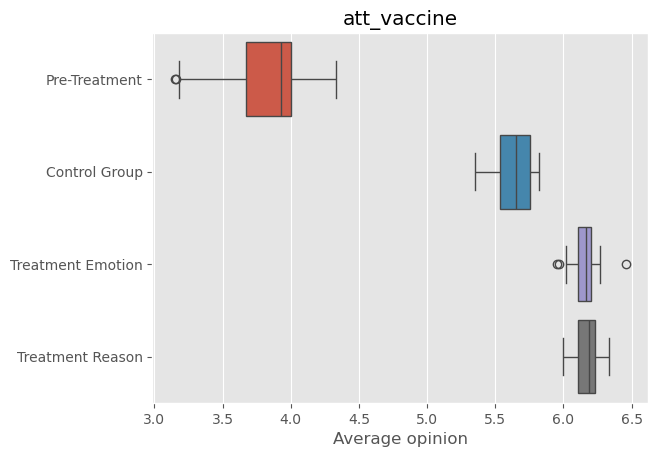

In [24]:
for att in base_att:
    sns.boxplot(data=[merged_df['pre_'+att].rename('Pre-Treatment'),
                 merged_df[~(merged_df['treatment_reason'].astype('bool') | merged_df['treatment_emotion'].astype('bool'))]['post_'+att].rename('Control Group'),
                 merged_df[merged_df['treatment_emotion'].astype('bool')]['post_'+att].rename('Treatment Emotion'),
                 merged_df[merged_df['treatment_reason'].astype('bool')]['post_'+att].rename('Treatment Reason')],
                 orient='h')
    plt.xlabel('Average opinion')
    plt.title(att)
    plt.show()

**End of Notebook**

---